In [14]:
%matplotlib inline

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import ipywidgets as widgets
import seaborn as sns
import cmyt
import utils_hb as hb

from matplotlib import transforms
from matplotlib.lines import Line2D
from functools import partial
from scipy.integrate import ode
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from ipywidgets import interactive
from tqdm import tqdm
from cycler import cycler


# Matplotlib settings
font = {'family' : 'serif',
        #'weight' : 'bold',
        'size'   : 14}

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rc('axes', prop_cycle=(cycler('color', ['#8F59C7', '#00BF9B', '#EC5F9B','#7D787A','#83C8E0','grey'])))

sns.set_style('whitegrid')


# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Kerr Model Simulation

## Intra-cavity simulations

Let us consider the following Heisenberg equation of motion:

$$ \dot{a} = -i \omega_0 a - \dfrac{\kappa_0}{2} a + i\dfrac{K}{2} |a|^2 a - \sqrt{\kappa_0^{ext}} a_{in}, $$

where $a$ is a complex magnitude describing the dynamics of the resonator, $\omega_0$ represents the resonant frequency of the system, $\kappa_0$ a linear damping, $K$ the Kerr type damping, $\kappa_0^{ext}$ the waveguide-resonator coupling, and $a_{in}$ the drives of the system.

The drives have the form:

$$ a_{in} = F_1 e^{-i (\omega_1 t + \varphi_1)} + F_2 e^{-i (\omega_2 t + \varphi_2)}.$$

In [16]:
# PARAMETERS

# resonator parameters
f0 = 0.000  # resonant frequency
kint = 1 / 30 #0.15
kext = 2 / 30 #0.3
k0 = kint + kext  # linear dissipation
k = 1e-5  # kerr term

# drive parameters
F1 = 1  # drive 1 amplitude
F2 = F1  # drive 2 amplitude
fd1 = -0.001  # drive 1 frequency
fd2 = 0.001  # drive 2 frequency
psi = -0.25 * np.pi

# Environment parameters
alpha = 0
beta = 0
phase_delay = alpha - beta  # phase delay between the input and output fields
gain = 2  # Output line gain
att = 1  # input line attenuation

# inital state
y0 = [1, 0]

# Integration parameters
df = 0.001
fs = 20
N = int(round(fs/df))
T = 1. / df
T_relax = 5 * T
dt = 1. / fs
time = dt * (np.arange((T + T_relax) / dt) + 1)

# Q factor
Q = 1 / (2 * k0)  # Quality factor
print('\033[1m' + 'Q factor: ' + '\033[0m' + f'{Q:.2f}' )

Q factor: 5.00


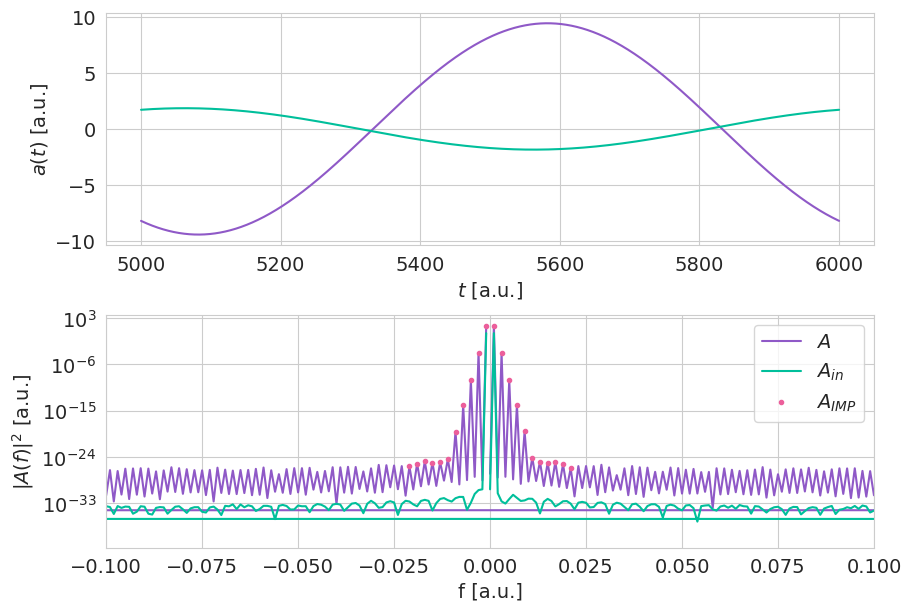

In [17]:
# run the integrator
A, a, f, t = hb.kerr_simulation(time_=time,
                                f0_=f0,
                                k0_=k0,
                                k_=k,
                                F1_=F1,
                                F2_=F2,
                                fd1_=fd1,
                                fd2_=fd2,
                                kext_=kext,
                                psi_=psi,
                                y0_=y0,
                                N_=N,
                                dt_=dt,
                                )


# Drives 
ain = F1 * np.exp(-1j * 2 * np.pi * fd1 * t) + F2 * np.exp(-1j * (2 * np.pi * fd2 * t + psi))
Ain = np.fft.fft(ain) / len(ain)

# IMPs
drives_ind = -np.array([int(fd1 / df), int(fd2 / df)])
nimps = 10
nstep = int((fd2 - fd1) / df)
imps_ind = np.arange(drives_ind[1] - nimps*nstep, drives_ind[0] + nimps*nstep + nstep, nstep)


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.real(a))
ax[0].plot(t, np.real(ain))
ax[1].semilogy(f, np.abs(A)**2, label=r'$A$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')
ax[1].semilogy(f[imps_ind], np.abs(A)[imps_ind]**2, '.', label=r'$A_{IMP}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$a(t)$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

### Harmonic balance reconstruction

We now want to reconstruct the parameters of the system using harmonic balance.
To do so, we first Fourier transform the equation of motion such that:

$$ i \omega {A} + i \omega_0 A + \dfrac{\kappa_0}{2} A - i \dfrac{K}{2} \mathscr{F}\left\{|a|^2 a\right\} = -\sqrt{\kappa_0^{ext}} A_{in}. $$

In matrix form, we have that:

$$ \begin{pmatrix} i \omega_k A_k & i A_k & A_k & -i\mathscr{F}\left\{ |a|^2 a \right\}_k \end{pmatrix} 
\begin{pmatrix} 1/\sqrt{\kappa_0^{ext}} \\ \omega_0 \sqrt{\kappa_0^{ext}} \\ \kappa_0/2 \sqrt{\kappa_0^{ext}} \\ K/2\sqrt{\kappa_0^{ext}} \end{pmatrix} = -A_{in,k}. $$

In this way, we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain the least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

We then insert our simulated (only the IMP frequencies) data into the harmonic balance algorithm, obtaining:

In [18]:
# Reconstruction using the complex time-domain spectra
kext_rec, f0_rec, k0_rec, k_rec, Q_fit = hb.kerr_reconstruction(Field=A,
                                                                Field_in=Ain,
                                                                field=a,
                                                                field_in=ain,
                                                                freqs=f,
                                                                indices=imps_ind,
                                                                in_out=False,
                                                                )

# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter','Simulation','Reconstruction') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format('kext', f'{kext:.3f}', f'{kext_rec:.3f}'))
print('{:<15} {:<15} {:<15}'.format('f0', f'{f0:.5f} Hz', f'{f0_rec:.5f} Hz'))
print('{:<15} {:<15} {:<15}'.format('κ', f'{k0:.3e}', f'{k0_rec:.3e}'))
print('{:<15} {:<15} {:<15}'.format('K', f'{k:.3e}', f'{k_rec:.3e}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction 
kext            0.067           0.067          
f0              0.00000 Hz      -0.00000 Hz    
κ               1.000e-01       1.000e-01      
K               1.000e-05       1.000e-05      


We eventually solve again the differential equation using the reconstructed parameters.

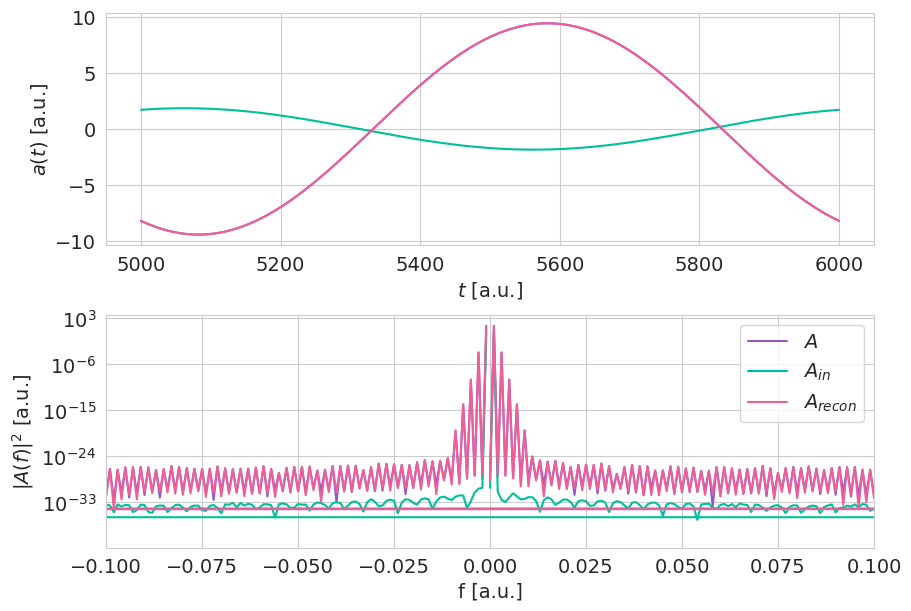

In [19]:
# run the integrator
A_rec, a_rec, _, _ = hb.kerr_simulation(time_=time,
                                        f0_=f0_rec,
                                        k0_=k0_rec,
                                        k_=k_rec,
                                        F1_=F1,
                                        F2_=F2,
                                        fd1_=fd1,
                                        fd2_=fd2,
                                        kext_=kext_rec,
                                        psi_=psi,
                                        y0_=y0,
                                        N_=N,
                                        dt_=dt,
                                        )


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.real(a))
ax[0].plot(t, np.real(ain))
ax[0].plot(t, np.real(a_rec))
ax[1].semilogy(f, np.abs(A)**2, label=r'$A$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')
ax[1].semilogy(f, np.abs(A_rec)**2, label=r'$A_{recon}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$a(t)$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

As a sanity check, I print the product $\bar{\bar{H}} \bar{p}$, which should be a matrix full of zeros, except for the two drives frequencies.

In [20]:
print(Q_fit)

[ 4.16308887e-14  8.77143227e-14 -1.72060132e-13  3.22092157e-14
  8.05799303e-14 -7.71837884e-14  2.02658563e-13 -1.93465448e-13
 -6.91805757e-14 -1.19665129e-12 -7.07106781e-01 -1.00000000e+00
 -1.28605590e-12  5.41218117e-13 -1.94762063e-13 -1.38323651e-13
  6.01791826e-14 -1.02184966e-13  9.75199316e-14  6.14241256e-14
 -8.09159887e-14  2.61069841e-14 -5.12628601e-14  7.42362976e-14
  2.03863241e-14 -1.10938041e-13  8.53633344e-14 -1.06612056e-13
  3.67992585e-14  3.74739379e-13 -6.56059486e-13  3.04176606e-12
 -7.07106781e-01  5.89380975e-14  2.95218624e-12  4.52202938e-13
  3.75573531e-13 -9.75219797e-14 -1.03545558e-14 -7.54607967e-14
 -5.57756860e-14  1.37155003e-13 -5.72817015e-14 -3.47908047e-14]


### Input-output 

Let us consider now the case where we have our Duffing resonator coupled to a transmission line in a refection configuration.
The intra-cavity field is given by the following input-output relation:

$$ e^{i\beta} \dfrac{a_{out}}{\sqrt{\mathcal{G}}} = \sqrt{\kappa_0^{ext}} a + e^{i\alpha} \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \quad \rightarrow \quad a = \dfrac{1}{\sqrt{\kappa_0^{ext}}} e^{i\beta} \left( \dfrac{a_{out}}{\sqrt{\mathcal{G}}} + e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}} \right), $$

where $\mathcal{G}$ and $\mathcal{A}$ are the gain and attenuation of the output and input line respectively, $\kappa_0^{ext} \in \mathbb{R}$ represents the waveguide-resonator coupling rate, and $\beta$, $\alpha$ simbolize the phase picked by the signal while passing through the input and output lines respectively.

To calculate the output field, we need the phase delay $\phi$, and the gain $\mathcal{G}$ and attenuation $\mathcal{A}$ of our input and output lines.
To obtain these parameters, we use an out-of-resonance measurement.

#### Out-of-resonance measurement

Typically, the phase delay $\phi$ and the attenuation $\mathcal{A}$ are parameters not easy to obtain experimentally.
Therefore, to obtain the phase delay $\phi$ between the input and output fields, we analyze the out-of-resonance system.

The input-output relation out of resonance is given by

$$ \dfrac{a_{out}}{\sqrt{\mathcal{G}}} = e^{i\phi} \dfrac{a_{in}}{\sqrt{\mathcal{A}}}. $$

In the frequency domain:

$$ \dfrac{A_{out,k}}{\sqrt{\mathcal{G}}} = e^{i\phi} \dfrac{A_{in,k}}{\sqrt{\mathcal{A}}} \quad \rightarrow \quad e^{i\phi}\sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} = \dfrac{A_{out,k}}{A_{in,k}} $$

If we introduce the input and output fields in the EOM, we get:

$$ \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}}  \dot{a}_{in} = -i \left(\omega_0 - i \dfrac{\kappa_0}{2}\right) \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}}  a_{in} \right) + i \dfrac{K}{2\mathcal{G}\kappa_0^{ext}} \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \kappa_0^{ext} e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}. $$

Solving this equation of motion applying two drives out of resonance, we obtain:

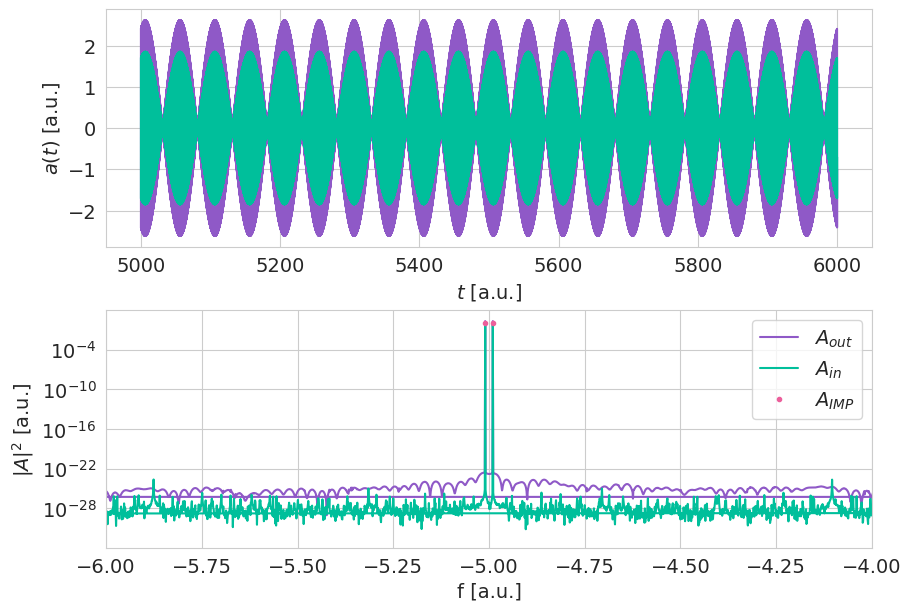

In [21]:
# drive parameters
fd1_off = 4.99  # drive 1 frequency
fd2_off = 5.01  # drive 2 frequency

# run the integrator
Aout_off, aout_off, _, _ = hb.kerr_simulation(time_=time,
                                              f0_=f0,
                                              k0_=k0,
                                              k_=k,
                                              F1_=F1,
                                              F2_=F2,
                                              fd1_=fd1_off,
                                              fd2_=fd2_off,
                                              kext_=kext,
                                              psi_=psi,
                                              phase_=phase_delay,
                                              gain_=gain,
                                              att_=att,
                                              in_out=True,
                                              y0_=y0,
                                              N_=N,
                                              dt_=dt,
                                              )

# Drives 
ain_off = F1 * np.exp(-1j * 2 * np.pi * fd1_off * t) + F2 * np.exp(-1j * (2 * np.pi * fd2_off * t + psi))
Ain_off = np.fft.fft(ain_off) / len(ain_off)

# IMPs
drives_ind_off = -np.array([int(fd1_off / df), int(fd2_off / df)])


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.real(aout_off))
ax[0].plot(t, np.real(ain_off))
ax[1].semilogy(f, np.abs(Aout_off)**2, label=r'$A_{out}$')
ax[1].semilogy(f, np.abs(Ain_off)**2, label=r'$A_{in}$')
ax[1].semilogy(f[drives_ind_off], np.abs(Ain_off[drives_ind_off])**2, '.', label=r'$A_{IMP}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$a(t)$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-6, -4])
ax[1].legend()

plt.show()

Recovering the phase delay and the gain and attenuation ratio.

In [22]:
# Reconstructed phase
phase_factor_rec = Aout_off[drives_ind_off[0]] / Ain_off[drives_ind_off[0]]
# phase_factor_rec = Aout_off[drives_ind_off[1]] / Ain_off[drives_ind_off[1]]

print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter','Simulation','Reconstruction') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format(r'√(G/A)', f'{np.sqrt(gain / att):.5f}', f'{np.abs(phase_factor_rec):.5f}'))
print('{:<15} {:<15} {:<15}'.format(r'φ', f'{phase_delay:.5f}', f'{np.angle(phase_factor_rec):.5f}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction 
√(G/A)          1.41421         1.41421        
φ               0.00000         -0.00213       


We then reconstruct the output field for the on-resonance measurement, and plot it together with the intra-cavity and input fields.

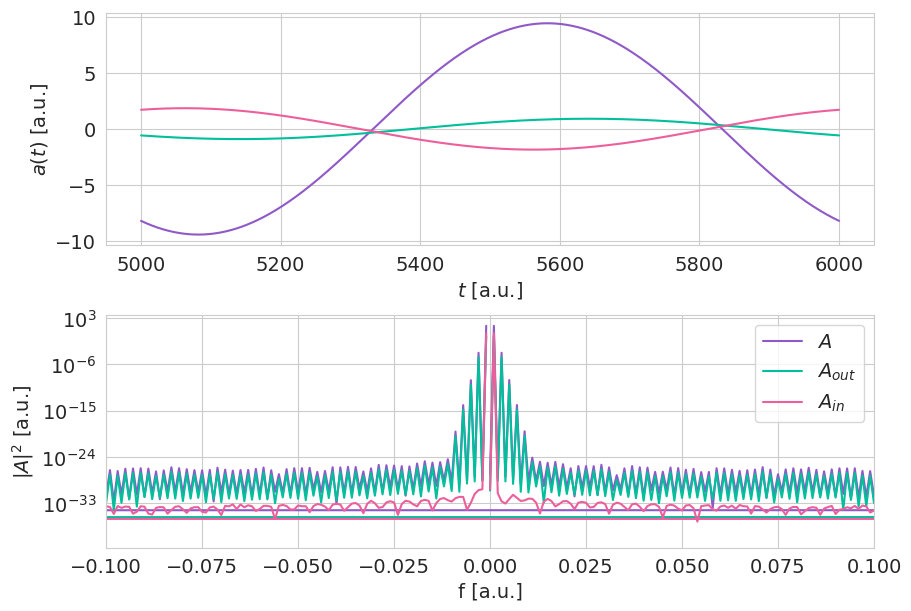

In [23]:
# We assume the gain known, and calculate the attenuation as:
att_rec = gain / np.abs(phase_factor_rec)**2
phase_delay_rec = np.angle(phase_factor_rec)

# output field
aout = np.sqrt(gain) * np.exp(1.0j * beta) * (np.sqrt(kext_rec) * a_rec + 
                                              np.exp(1.0j * phase_delay_rec) * ain / np.sqrt(att_rec))
Aout = np.fft.fft(aout) / len(aout)


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.real(a))
ax[0].plot(t, np.real(aout))
ax[0].plot(t, np.real(ain))
ax[1].semilogy(f, np.abs(A)**2, label=r'$A$')
ax[1].semilogy(f, np.abs(Aout)**2, label=r'$A_{out}$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$a(t)$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

As a sanity check, we solve the equation of motion for the output field, and compare the result to the field we obtained using the input-output relation.  

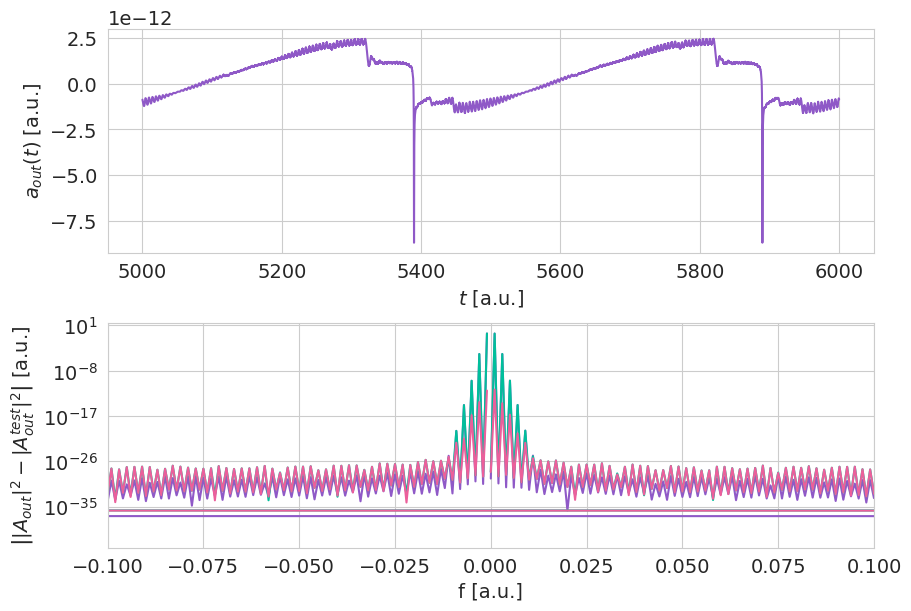

In [24]:
verbose = False

# Output field solving the eom for the intra cavity field and then applying the in-out relation
aout_1 = np.sqrt(gain) * np.exp(1.0j * beta) * (np.sqrt(kext) * a + 
                                                np.exp(1.0j * phase_delay) * ain / np.sqrt(att))
Aout_1 = np.fft.fft(aout_1) / len(aout_1)

# Output field solving the eom for the output field 
Aout_2, aout_2, f, t = hb.kerr_simulation(time_=time,
                                          f0_=f0,
                                          k0_=k0,
                                          k_=k,
                                          F1_=F1,
                                          F2_=F2,
                                          fd1_=fd1,
                                          fd2_=fd2,
                                          kext_=kext,
                                          psi_=psi,
                                          phase_=phase_delay,
                                          gain_=gain,
                                          att_=att,
                                          y0_=y0,
                                          N_=N,
                                          dt_=dt,
                                          in_out=True
                                          )

if verbose:
    print(np.max(np.abs(np.abs(Aout_1)**2 - np.abs(Aout_2)**2)))


# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.abs(aout_1) - np.abs(aout_2))
ax[1].semilogy(f, np.abs(Aout_2)**2)
ax[1].semilogy(f, np.abs(Aout_1)**2)
ax[1].semilogy(f, np.abs(np.abs(Aout_1)**2 - np.abs(Aout_2)**2))

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$a_{out}(t)$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel(r'$\left| |A_{out}|^2 - |A_{out}^{test}|^2 \right| $ [a.u.]')
ax[1].set_xlim([-df*100, df*100])

plt.show()

### Parameter Dependence

I want to check now how stable is the reconstruction (and the simulation) as we sweep some parameters.

#### Drive frequency sweep

Let us start sweeping the drive frequencies of the system. 
We define $f_c$ as the frequency centered between the two drive tones, i.e. $f_c = \dfrac{f_{d1} + f_{d2}}{2}$.

In [25]:
verbose = True

# resonator parameters
fd_start = -0.1
fd_stop = 0.1
n_start = int(round(fd_start / df))
n_stop = int(round(fd_stop / df))
n_arr = np.arange(n_start, n_stop + 1)
nr_freq = len(n_arr)
fd_arr = df * n_arr


# Empty arrays
kext_rec_i = np.zeros_like(fd_arr)
f0_rec_i = np.zeros_like(fd_arr)
k0_rec_i = np.zeros_like(fd_arr)
k_rec_i = np.zeros_like(fd_arr)

A_i_arr = np.zeros((len(fd_arr), int(fs/df)), dtype=complex)
a_i_arr = np.zeros_like(A_i_arr)
ain_i_arr = np.zeros_like(A_i_arr)
Ain_i_arr = np.zeros_like(A_i_arr)

drive_ind_arr = np.zeros((len(fd_arr), 2), dtype=int)
imp_ind_arr = np.zeros((len(fd_arr), 2*nimps+2), dtype=int)

# Simulation
with tqdm(total=len(fd_arr), ncols=80) as pbar:
    for fd_idx, fd_val in enumerate(fd_arr):
        fd1_val = fd_val - df
        fd2_val = fd_val + df

        # Output field
        A_i_arr[fd_idx], a_i_arr[fd_idx], f, t = hb.kerr_simulation(time_=time,
                                                                    f0_=f0,
                                                                    k0_=k0,
                                                                    k_=k,
                                                                    F1_=F1,
                                                                    F2_=F2,
                                                                    fd1_=fd1_val,
                                                                    fd2_=fd2_val,
                                                                    kext_=kext,
                                                                    psi_=psi,
                                                                    y0_=y0,
                                                                    N_=N,
                                                                    dt_=dt,
                                                                    )
        
        # Input field
        ain_i_arr[fd_idx] = F1 * (np.exp(-1j * 2 * np.pi * fd1_val * t) + np.exp(-1j * (2 * np.pi * fd2_val * t + psi)))
        Ain_i_arr[fd_idx] = np.fft.fft(ain_i_arr[fd_idx]) / len(ain_i_arr[fd_idx])
        
        # Drive indices
        drive_ind_arr[fd_idx] = -np.array([int(round(fd1_val / df, 1)), int(round(fd2_val / df, 1))])
        # IMPs indices
        nstep = drive_ind_arr[fd_idx, 0] - drive_ind_arr[fd_idx, 1]
        imp_ind_arr[fd_idx] = np.arange(drive_ind_arr[fd_idx, 1] - nimps*nstep,
                                        drive_ind_arr[fd_idx, 0] + nimps*nstep + nstep, 
                                        nstep)
        
        if verbose:
            # Reconstruction
            kext_rec_i[fd_idx], f0_rec_i[fd_idx], k0_rec_i[fd_idx], k_rec_i[fd_idx], _ = hb.kerr_reconstruction(A_i_arr[fd_idx], 
                                                                                                                Ain_i_arr[fd_idx],
                                                                                                                a_i_arr[fd_idx], 
                                                                                                                ain_i_arr[fd_idx],
                                                                                                                f, 
                                                                                                                imp_ind_arr[fd_idx],
                                                                                                                )
    
        pbar.update(1)

  0%|                                                   | 0/201 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 201/201 [03:11<00:00,  1.05it/s]


In [26]:
# Plot: steady-state fields in the time and frequency domain

def plot_sweep(fd_idx):
    # IMPs
    indices_ = imp_ind_arr[fd_idx]
    
    # Plotting
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.real(a_i_arr[fd_idx]))
    ax[0].plot(t, np.real(ain_i_arr[fd_idx]))
    ax[1].semilogy(f, np.abs(A_i_arr[fd_idx])**2, label=r'$A_{out}$')
    ax[1].semilogy(f, np.abs(Ain_i_arr[fd_idx])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[indices_], np.abs(A_i_arr[fd_idx])[indices_]**2, '.', label=r'$A_{in}$')

    # labels
    ax[0].set_title(r'$f_c$' + f' = {fd_arr[fd_idx]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$a(t)$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([-df*200, df*200])
    ax[1].set_ylim([np.min(np.abs(A_i_arr)**2)/10, np.max(np.abs(A_i_arr)**2)*10])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_sweep,
                 fd_idx=widgets.IntSlider(min=0,
                                          max=len(fd_arr)-1,
                                          step=1,
                                          description='fd ind',
                                         )
                )
plt.show()

interactive(children=(IntSlider(value=0, description='fd ind', max=200), Output()), _dom_classes=('widget-inte…

We can plot the different spectra as a function of $f_c$ to observe how the IMPs dissapear as we move away from the resonant frequency.

In [27]:
def arrange_spectra(A_, f_, fs_, df_, f_lim_, fd_arr_):
    
    # Rearrange the arrays so that negative frequencies correspond to [0:n/2] and positive to [n/2+1:]
    freq = np.zeros_like(f_, dtype=float)
    freq[:int(fs_/df_/2)] = f[int(fs_/df_/2):]
    freq[int(fs_/df_/2)] = f[0]
    freq[int(fs_/df_/2)+1:] = f[1:int(fs_/df_/2)]
    
    spectra = np.zeros_like(A_, dtype=float)
    spectra[:, :int(fs_/df_/2)] = 20 * np.log10(np.abs(A_[:, int(fs_/df_/2):]))
    spectra[:, int(fs_/df_/2)] = 20 * np.log10(np.abs(A_[:, 0]))
    spectra[:, int(fs_/df_/2)+1:] = 20 * np.log10(np.abs(A_[:, 1:int(fs_/df_/2)]))
    
    # Arrays for plotting    
    freq_plot = freq[int(fs_/df_/2)-f_lim_:int(fs_/df_/2)+f_lim_]
    spectra_plot = np.zeros_like(spectra[:, :2*f_lim_])
    for fd_idx, fd_val in enumerate(fd_arr_):
        index = int(np.round(fd_val / df_, 1))
        spectra_plot[fd_idx, :] = spectra[fd_idx, int(fs_/df_/2)-f_lim_-index:int(fs_/df_/2)+f_lim_-index]
    
    return spectra_plot, freq_plot


def plot_2D_freq_sweep(A_, f_, fd_arr_, fig, ax):
    
    # Plot all spectra
    zmax = np.max(A_) 
    zmin = np.min(A_) 

    c = ax[0].pcolormesh(f_,
                         fd_arr_,
                         A_,
                         vmin=zmin,
                         vmax=zmax,
                         cmap="viridis",
                         rasterized=True,
                        )

    ax[0].set_xlabel('$f-f_c$ [a.u]')
    ax[0].set_ylabel('$f_c - f_r$ [a.u.]')    

    # Plot IMPs strength
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1)], 'o-',label="Drive", c='#1A7CA1', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+nstep)], 'o-', label=r"$3^{rd}$ order", c='#AE80DC', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+2*nstep)], 'o-', label=r"$5^{th}$ order", c='#00BF9B', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+3*nstep)], 'o-', label=r"$7^{th}$ order", c='#EC5F9B', markersize=5)
    ax[1].plot(fd_arr_, A_[:, int(len(f_)/2+1+4*nstep)], 'o-', label=r"$9^{th}$ order", c='#83C8E0', markersize=5)
#     ax[1].plot(fd_arr, spectra_plot[:, -1], 'o-', label="Background", c = '#7D787A', markersize=5)
    ax[1].set_xlabel('$f_c - f_r$ [a.u.]') 
    
    ax[1].legend(loc='best')
    
    return fig, ax, c

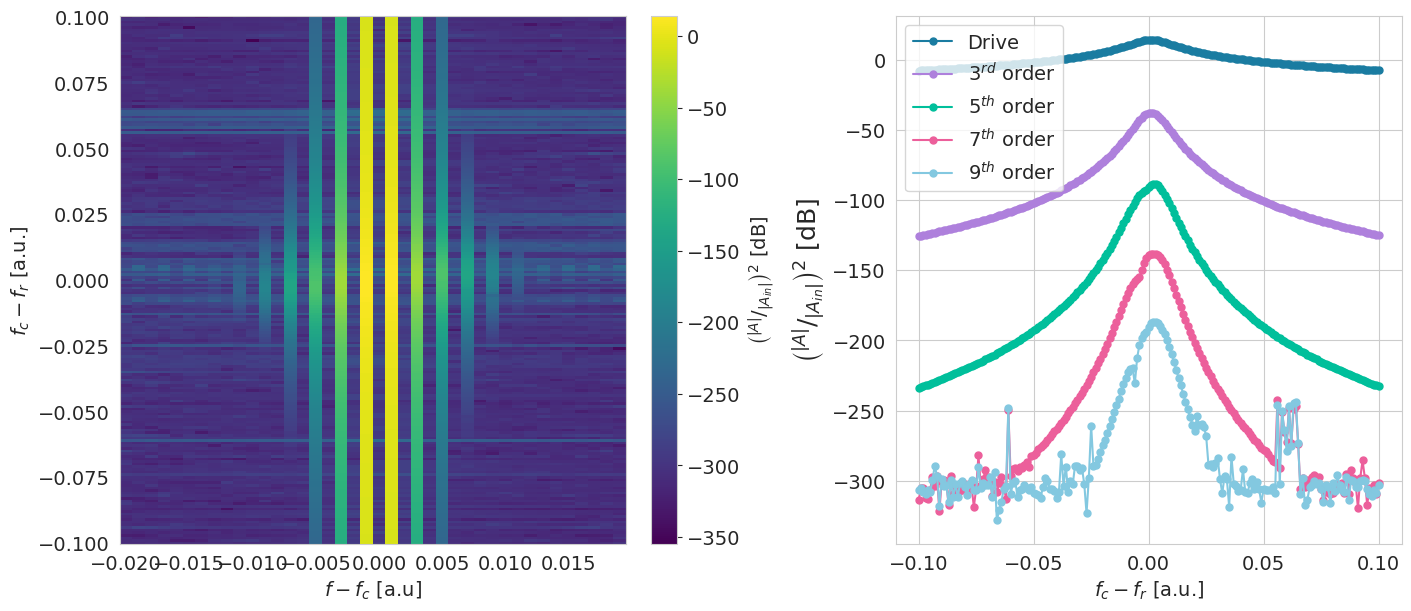

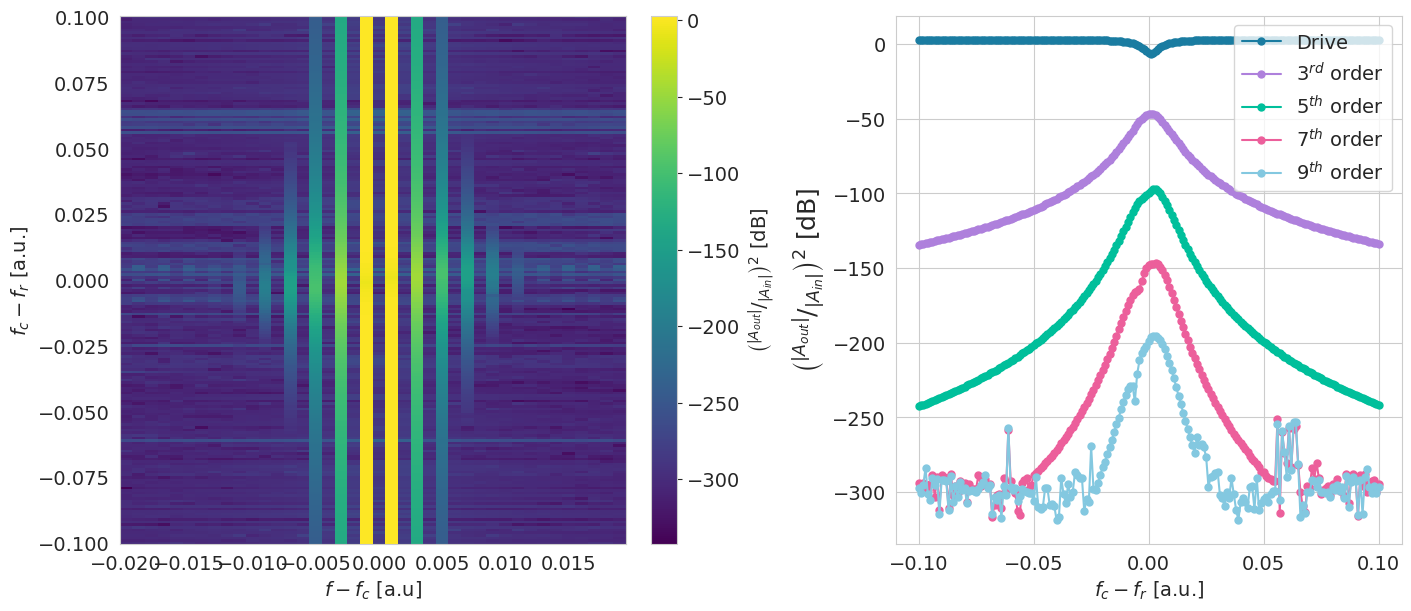

In [28]:
# 2D frequency sweep plot
f_lim = int(0.02 / df)

Aout_1_test = np.sqrt(gain) * (np.sqrt(kext) * A_i_arr + np.exp(1.0j * phase_delay) * Ain_i_arr / np.sqrt(att))
# Aout_1_test = np.fft.fft(aout_1_test) / len(aout_1_test)

spectra, freqs = arrange_spectra(A_i_arr/F1, f, fs, df, f_lim, fd_arr)
spectra_test, _ = arrange_spectra(Aout_1_test/F1, f, fs, df, f_lim, fd_arr)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig, ax, cmap = plot_2D_freq_sweep(spectra, freqs, fd_arr, fig, ax)

fig.colorbar(cmap, ax=ax[0], label=r'$ \left( ^{|A|}/_{|A_{in}|} \right)^2$ [dB]')
ax[1].set_ylabel(r'$ \left( ^{|A|}/_{|A_{in}|} \right)^2$ [dB]', fontsize=18)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig, ax, cmap = plot_2D_freq_sweep(spectra_test, freqs, fd_arr, fig, ax)

fig.colorbar(cmap, ax=ax[0], label=r'$ \left( ^{|A_{out}|}/_{|A_{in}|} \right)^2$ [dB]')
ax[1].set_ylabel(r'$ \left( ^{|A_{out}|}/_{|A_{in}|} \right)^2$ [dB]', fontsize=18)

plt.show()

We then perform the harmonic balance reconstruction at the different frequencies obtaining the following parameters.

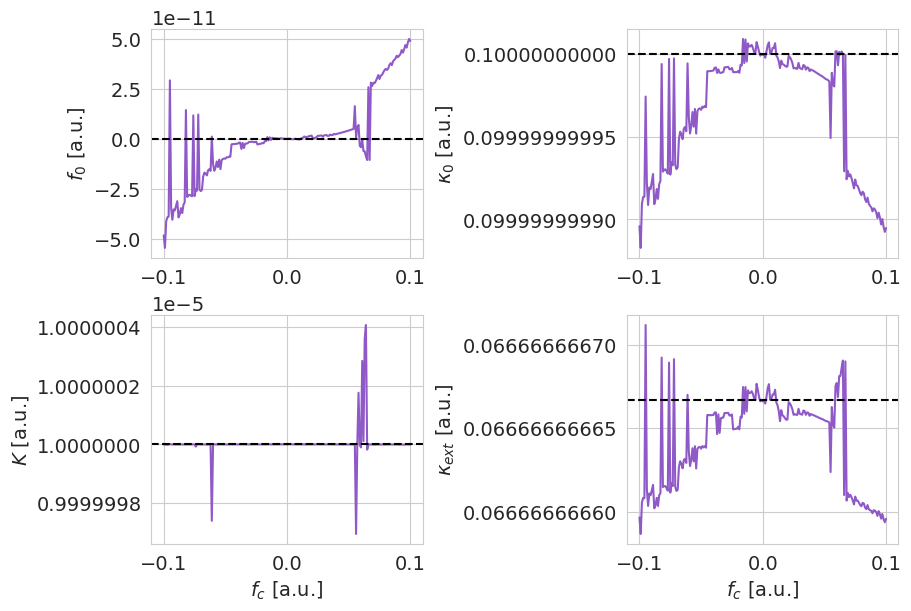

In [29]:
# Plot reconstructed parameters
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

ax[0, 0].plot(fd_arr, f0_rec_i)
ax[0, 0].axhline(f0, ls='--', c='black')
ax[0, 1].plot(fd_arr, k0_rec_i)
ax[0, 1].axhline(k0, ls='--', c='black')
ax[1, 0].plot(fd_arr, k_rec_i)
ax[1, 0].axhline(k, ls='--', c='black')
ax[1, 1].plot(fd_arr, kext_rec_i)
ax[1, 1].axhline(kext, ls='--', c='black')

# labels
ax[1, 0].set_xlabel('$f_c$ [a.u.]')
ax[1, 1].set_xlabel('$f_c$ [a.u.]')
ax[0, 0].set_ylabel('$f_0$ [a.u.]')
ax[1, 0].set_ylabel('$K$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')

plt.show()

#### Drive power sweep

We now sweep the drive strength $ F_0$, and again reconstruct the system using the harmonic balance technique to recover the parameters of the system as a function of the pump strengths.

In [30]:
# drive parameters
F1_arr = np.logspace(-2, 3, 200)  # drive 1 amplitude


# Empty arrays
kext_rec_ii = np.zeros_like(F1_arr)
f0_rec_ii = np.zeros_like(F1_arr)
k0_rec_ii = np.zeros_like(F1_arr)
k_rec_ii = np.zeros_like(F1_arr)

A_ii_arr = np.zeros((len(F1_arr), int(fs/df)), dtype=complex)
a_ii_arr = np.zeros_like(A_ii_arr)
ain_ii_arr = np.zeros_like(A_ii_arr)
Ain_ii_arr = np.zeros_like(A_ii_arr)

# Simulation
with tqdm(total=len(F1_arr), ncols=80) as pbar:
    for F_idx, F_val in enumerate(F1_arr):

        # run the integrator
        A_ii_arr[F_idx], a_ii_arr[F_idx], f, t = hb.kerr_simulation(time_=time,
                                                                    f0_=f0,
                                                                    k0_=k0,
                                                                    k_=k,
                                                                    F1_=F_val,
                                                                    F2_=F_val,
                                                                    fd1_=fd1,
                                                                    fd2_=fd2,
                                                                    kext_=kext,
                                                                    psi_=psi,
                                                                    y0_=y0,
                                                                    N_=N,
                                                                    dt_=dt,
                                                                    )
        
        # input field
        ain_ii_arr[F_idx] = F_val * (np.exp(-1j * 2 * np.pi * fd1 * t) + np.exp(-1j * (2 * np.pi * fd2 * t + psi)))
        Ain_ii_arr[F_idx] = np.fft.fft(ain_ii_arr[F_idx]) / len(ain_ii_arr[F_idx])

        # Reconstruction
        kext_rec_ii[F_idx], f0_rec_ii[F_idx], k0_rec_ii[F_idx], k_rec_ii[F_idx], _ = hb.kerr_reconstruction(A_ii_arr[F_idx], 
                                                                                                            Ain_ii_arr[F_idx],
                                                                                                            a_ii_arr[F_idx], 
                                                                                                            ain_ii_arr[F_idx],
                                                                                                            f, 
                                                                                                            imps_ind,
                                                                                                            )

        pbar.update(1)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 200/200 [03:08<00:00,  1.06it/s]


In [31]:
# Plot: steady-state fields in the time and frequency domain

def plot_power_sweep(F0_ind):
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.real(a_ii_arr[F0_ind]))
    ax[0].plot(t, np.real(ain_ii_arr[F0_ind]))
    ax[1].semilogy(f, np.abs(A_ii_arr[F0_ind])**2, label=r'$A$')
    ax[1].semilogy(f, np.abs(Ain_ii_arr[F0_ind])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[imps_ind], np.abs(A_ii_arr[F0_ind])[imps_ind]**2, '.', label=r'$A_{IMP}$')

    # labels
    ax[0].set_title(r'$F_0$' + f' = {F1_arr[F0_ind]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$a(t)$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A|^2$ [a.u.]')
    ax[1].set_xlim([-df*100, df*100])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_power_sweep,
                 F0_ind=widgets.IntSlider(min=0,
                                          max=len(F1_arr)-1,
                                          step=1,
                                          description='F0 ind',
                                         )
                )


plt.show()

interactive(children=(IntSlider(value=0, description='F0 ind', max=199), Output()), _dom_classes=('widget-inte…

We now plot the power of the four strongest IMPs applied at resonance as a function of the applied drive power, given by $F_0^2$.

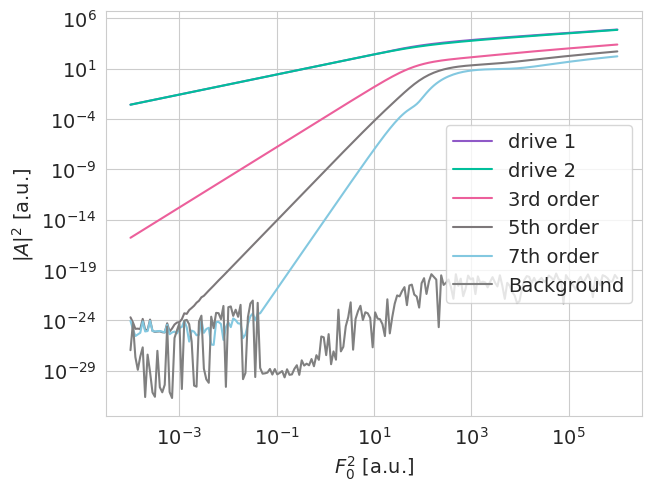

In [32]:
# Plot of IMPs and drive amplitudes
fig, ax = plt.subplots(1)

ax.loglog(F1_arr**2, np.abs(A_ii_arr[:, drives_ind[0]])**2, label='drive 1')
ax.loglog(F1_arr**2, np.abs(A_ii_arr[:, drives_ind[1]])**2, label='drive 2')
ax.loglog(F1_arr**2, np.abs(A_ii_arr[:, drives_ind[1]-nstep])**2, label='3rd order')
ax.loglog(F1_arr**2, np.abs(A_ii_arr[:, drives_ind[1]-2*nstep])**2, label='5th order')
ax.loglog(F1_arr**2, np.abs(A_ii_arr[:, drives_ind[1]-3*nstep])**2, label='7th order')
ax.loglog(F1_arr**2, np.abs(A_ii_arr[:, drives_ind[1]+3])**2, label='Background')

ax.set_ylabel('$|A|^2$ [a.u.]')
ax.set_xlabel('$F_0^2$ [a.u.]')
ax.legend(loc='right')

plt.show()

We now show the reconstructed parameters as a function of drive amplitude.

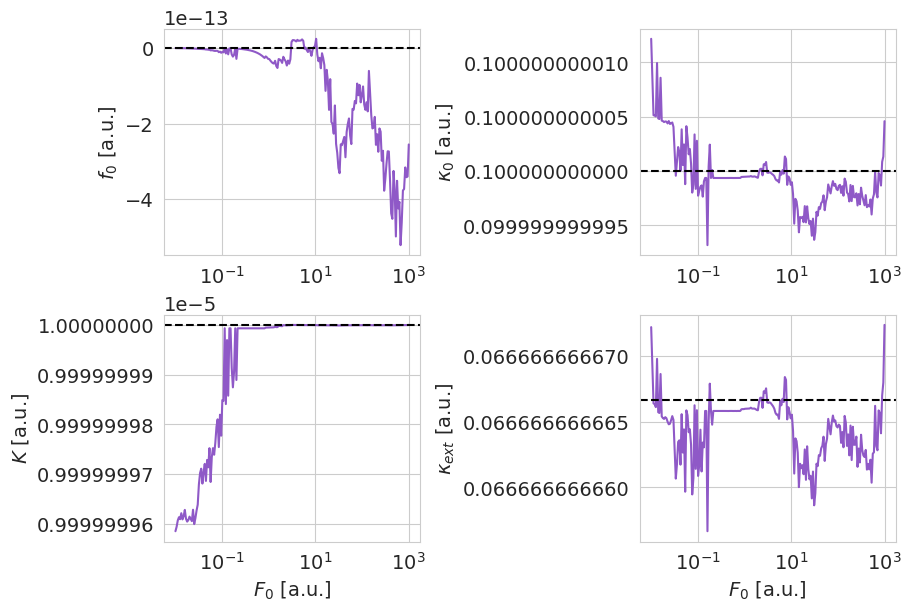

In [33]:
# Plot reconstructed parameters
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

ax[0, 0].semilogx(F1_arr, f0_rec_ii)
ax[0, 0].axhline(f0, ls='--', c='black')
ax[0, 1].semilogx(F1_arr, k0_rec_ii)
ax[0, 1].axhline(k0, ls='--', c='black')
ax[1, 0].semilogx(F1_arr, k_rec_ii)
ax[1, 0].axhline(k, ls='--', c='black')
ax[1, 1].semilogx(F1_arr, kext_rec_ii)
ax[1, 1].axhline(kext, ls='--', c='black')

# labels
ax[1, 0].set_xlabel('$F_0$ [a.u.]')
ax[1, 1].set_xlabel('$F_0$ [a.u.]')
ax[0, 0].set_ylabel('$f_0$ [a.u.]')
ax[1, 0].set_ylabel('$K$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')

plt.show()

## Output field simulations

In our experiment, we measure the output field and have no information about the intra-cavity field.
We now want to see if we are able to reconstruct the non-linear system applying harmonic balance directly on the output field.

To do so, we start simulating the output field using the input-output relation stated before and the equation of motion for the intra-cavity field.
The equation of motion for the output field reads:

$$ \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}}  \dot{a}_{in} = -i \left(\omega_0 - i \dfrac{\kappa_0}{2}\right) \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}}  a_{in} \right) + i \dfrac{K}{2\mathcal{G}\kappa_0^{ext}} \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) - \kappa_0^{ext} e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}. $$

We solve numerically the equation of motion obtaining the following spectrum:

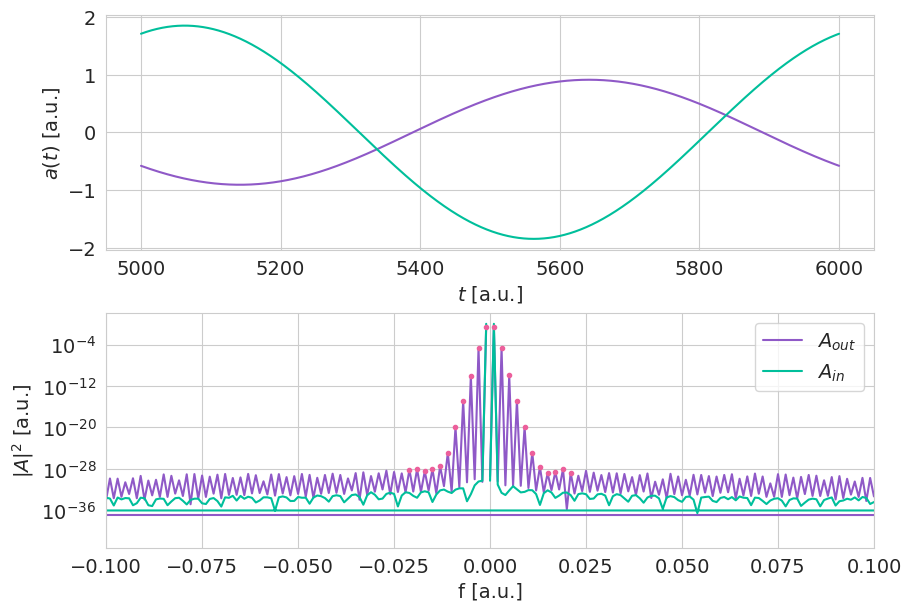

In [34]:
# Plot: steady-state fields in the time and frequency domain
fig, ax = plt.subplots(2, figsize=(9, 6))

# plot
ax[0].plot(t, np.real(aout_2))
ax[0].plot(t, np.real(ain))
ax[1].semilogy(f, np.abs(Aout_2)**2, label=r'$A_{out}$')
ax[1].semilogy(f, np.abs(Ain)**2, label=r'$A_{in}$')
ax[1].semilogy(f[imps_ind], np.abs(Aout_2[imps_ind])**2, '.')

# labels
ax[0].set_xlabel('$t$ [a.u.]')
ax[0].set_ylabel('$a(t)$ [a.u.]')
ax[1].set_xlabel('f [a.u.]')
ax[1].set_ylabel('$|A|^2$ [a.u.]')
ax[1].set_xlim([-df*100, df*100])
ax[1].legend()

plt.show()

### Harmonic balance reconstruction

We now write the eom in a matrix form, obtaining:

$$ \begin{pmatrix} \dot{a}_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{a}_{in} & i \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) & a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} & -i \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) \end{pmatrix} \begin{pmatrix} \frac{1}{\kappa_0^{ext}} \\ \frac{\omega_0}{\kappa_0^{ext}} \\ \frac{\kappa_0}{2\kappa_0^{ext}} \\ \frac{K}{2\mathcal{G}(\kappa_0^{ext})^2} \end{pmatrix} = -e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in}. $$


Transforming the eom to the Fourier domain, we get:

$$ \begin{pmatrix} \dot{A}_{out,k} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} \dot{A}_{in, k} & i \left( A_{out,k} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}}  A_{in, k} \right) & A_{out,k} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} A_{in,k} & -i \mathscr{F} \left\{ \left| a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right|^2 \left( a_{out} - e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} a_{in} \right) \right\}_k \end{pmatrix} \begin{pmatrix} \frac{1}{\kappa_0^{ext}} \\ \frac{\omega_0}{\kappa_0^{ext}} \\ \frac{\kappa_0}{2\kappa_0^{ext}} \\ \frac{K}{2\mathcal{G}(\kappa_0^{ext})^2} \end{pmatrix} = -e^{i\phi} \sqrt{\dfrac{\mathcal{G}}{\mathcal{A}}} A_{in,k}. $$


In this way, we divide the problem into a matrix $\bar{\bar{H}}$ containing the measurement information, a vector $\bar{p}$ with all the unknown parameters and another vector $\bar{q}$ containing the driving terms. To obtain the least squares best fit to the unknown parameters of the system, we use the pseudo-inverse of matrix $\bar{\bar{H}}$ such that
$$ \bar{p} = \bar{\bar{H}}^+ \bar{q}. $$

In [35]:
phase_factor_sim = np.sqrt(gain / att) * np.exp(1j * phase_delay)

# Reconstruction using the complex time-domain spectra
kext_rec, f0_rec, k0_rec, k_rec, Q_fit = hb.kerr_reconstruction(Aout_2, 
                                                                phase_factor_rec * Ain, 
                                                                aout_2, 
                                                                phase_factor_rec * ain,
                                                                f,
                                                                imps_ind,
                                                                in_out=True,
                                                                )
k_rec *= gain
# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15} {:<15}'.format('Parameter','Simulation','Reconstruction') + '\033[0m')
print('{:<15} {:<15} {:<15}'.format('κext', f'{kext:.5e}', f'{kext_rec:.5e}'))
print('{:<15} {:<15} {:<15}'.format('f0', f'{f0:.5e} Hz', f'{f0_rec:.5e} Hz'))
print('{:<15} {:<15} {:<15}'.format('κ', f'{k0:.3e}', f'{k0_rec:.3e}'))
print('{:<15} {:<15} {:<15}'.format('K', f'{k:.3e}', f'{k_rec:.3e}'))

RECONSTRUCTED PARAMETERS
Parameter       Simulation      Reconstruction 
κext            6.66667e-02     6.66655e-02    
f0              0.00000e+00 Hz  -4.42938e-06 Hz
κ               1.000e-01       1.000e-01      
K               1.000e-05       1.000e-05      


### Parameter Dependence


#### Drive frequency sweep

We now perform a drive frequency sweep along the resonance.
In a notch configuration, we expect a dip in the output field when on-resonance. 
However, we observe a dip, meaning probably that the input-output relation it is not correct.

In [36]:
# Empty arrays
kext_rec_i = np.zeros_like(fd_arr)
f0_rec_i = np.zeros_like(fd_arr)
k0_rec_i = np.zeros_like(fd_arr)
k_rec_i = np.zeros_like(fd_arr)

Aout_i_arr = np.zeros((len(fd_arr), int(fs/df)), dtype=complex)
aout_i_arr = np.zeros_like(Aout_i_arr)
ain_i_arr = np.zeros_like(Aout_i_arr)
Ain_i_arr = np.zeros_like(Aout_i_arr)

drive_ind_arr = np.zeros((len(fd_arr), 2), dtype=int)
imp_ind_arr = np.zeros((len(fd_arr), 2*nimps+2), dtype=int)

# Simulation
with tqdm(total=len(fd_arr), ncols=80) as pbar:
    for fd_idx, fd_val in enumerate(fd_arr):
        fd1_val = fd_val - df
        fd2_val = fd_val + df

        # Output field
        Aout_i_arr[fd_idx], aout_i_arr[fd_idx], f, t = hb.kerr_simulation(time_=time,
                                                                          f0_=f0,
                                                                          k0_=k0,
                                                                          k_=k,
                                                                          F1_=F1,
                                                                          F2_=F2,
                                                                          fd1_=fd1_val,
                                                                          fd2_=fd2_val,
                                                                          kext_=kext,
                                                                          psi_=psi,
                                                                          gain_=gain,
                                                                          att_=att,
                                                                          phase_=phase_delay,
                                                                          y0_=y0,
                                                                          N_=N,
                                                                          dt_=dt,
                                                                          in_out=True
                                                                          )
        
        # Input field
        ain_i_arr[fd_idx] = F1 * (np.exp(-1j * 2 * np.pi * fd1_val * t) + np.exp(-1j * (2 * np.pi * fd2_val * t + psi)))
        Ain_i_arr[fd_idx] = np.fft.fft(ain_i_arr[fd_idx]) / len(ain_i_arr[fd_idx])
        
        # Drive indices
        drive_ind_arr[fd_idx] = -np.array([int(round(fd1_val / df, 1)), int(round(fd2_val / df, 1))])
        # IMPs indices
        nstep = drive_ind_arr[fd_idx, 0] - drive_ind_arr[fd_idx, 1]
        imp_ind_arr[fd_idx] = np.arange(drive_ind_arr[fd_idx, 1] - nimps*nstep,
                                        drive_ind_arr[fd_idx, 0] + nimps*nstep + nstep, 
                                        nstep)
        
        if verbose:
            # Reconstruction
            kext_rec_i[fd_idx], f0_rec_i[fd_idx], k0_rec_i[fd_idx], k_rec_i[fd_idx], Q_fit = hb.kerr_reconstruction(Aout_i_arr[fd_idx], 
                                                                                                                    phase_factor_sim * Ain_i_arr[fd_idx],
                                                                                                                    aout_i_arr[fd_idx], 
                                                                                                                    phase_factor_sim * ain_i_arr[fd_idx],
                                                                                                                    f,
                                                                                                                    imp_ind_arr[fd_idx],
                                                                                                                    in_out=True,
                                                                                                                    )
            k_rec_i[fd_idx] *= gain
            
        pbar.update(1)

  0%|                                                   | 0/201 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 201/201 [03:48<00:00,  1.14s/it]


In [37]:
# Plot: steady-state fields in the time and frequency domain

def plot_sweep(fd_idx):
    # IMPs
    indices_ = imp_ind_arr[fd_idx]
    
    # Plotting
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.real(aout_i_arr[fd_idx]))
    ax[0].plot(t, np.real(ain_i_arr[fd_idx]))
    ax[1].semilogy(f, np.abs(Aout_i_arr[fd_idx])**2, label=r'$A_{out}$')
    ax[1].semilogy(f, np.abs(Ain_i_arr[fd_idx])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[indices_], np.abs(Aout_i_arr[fd_idx])[indices_]**2, '.', label=r'$A_{in}$')

    # labels
    ax[0].set_title(r'$f_c$' + f' = {fd_arr[fd_idx]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$a(t)$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A(f)|^2$ [a.u.]')
    ax[1].set_xlim([-df*200, df*200])
    ax[1].set_ylim([np.min(np.abs(Aout_i_arr)**2)/10, np.max(np.abs(Aout_i_arr)**2)*10])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_sweep,
                 fd_idx=widgets.IntSlider(min=0,
                                          max=len(fd_arr)-1,
                                          step=1,
                                          description='fd ind',
                                         )
                )
plt.show()

interactive(children=(IntSlider(value=0, description='fd ind', max=200), Output()), _dom_classes=('widget-inte…

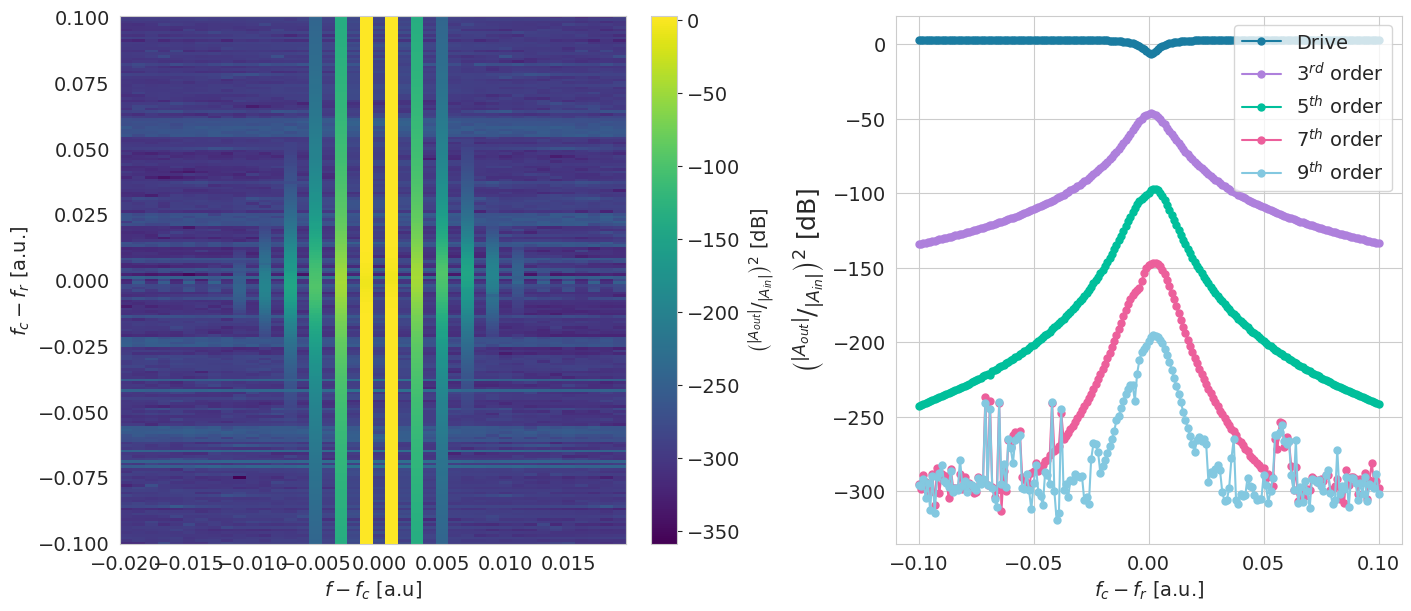

In [38]:
# 2D frequency sweep plot
f_lim = int(0.02 / df)

spectra, freqs = arrange_spectra(Aout_i_arr/F1, f, fs, df, f_lim, fd_arr)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig, ax, cmap = plot_2D_freq_sweep(spectra, freqs, fd_arr, fig, ax)
fig.colorbar(cmap, ax=ax[0], label=r'$ \left( ^{|A_{out}|}/_{|A_{in}|} \right)^2$ [dB]')
ax[1].set_ylabel(r'$ \left( ^{|A_{out}|}/_{|A_{in}|} \right)^2$ [dB]', fontsize=18)

plt.show()

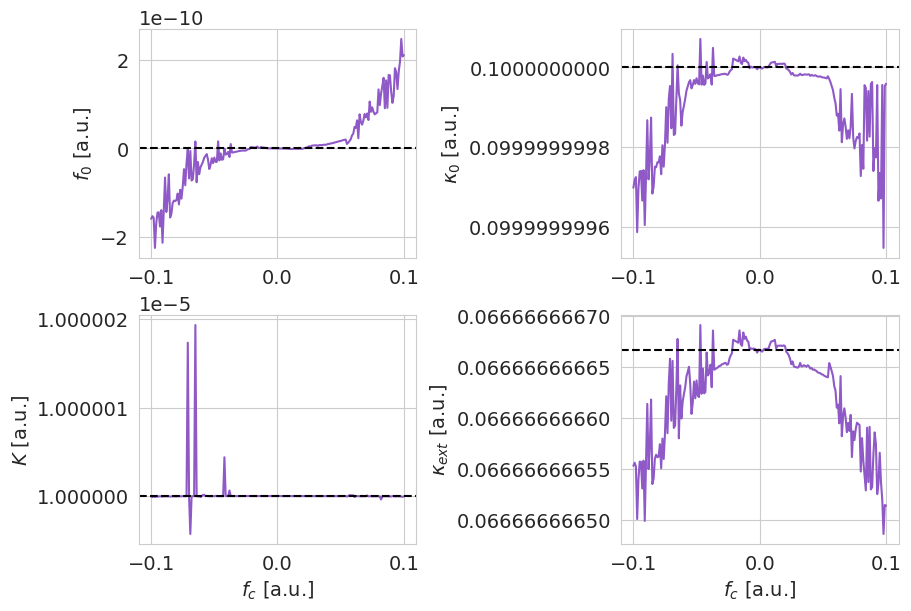

In [39]:
# Plot reconstructed parameters
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

ax[0, 0].plot(fd_arr, f0_rec_i)
ax[0, 0].axhline(f0, ls='--', c='black')
ax[0, 1].plot(fd_arr, k0_rec_i)
ax[0, 1].axhline(k0, ls='--', c='black')
ax[1, 0].plot(fd_arr, k_rec_i)
ax[1, 0].axhline(k, ls='--', c='black')
ax[1, 1].plot(fd_arr, kext_rec_i)
ax[1, 1].axhline(kext, ls='--', c='black')

# labels
ax[1, 0].set_xlabel('$f_c$ [a.u.]')
ax[1, 1].set_xlabel('$f_c$ [a.u.]')
ax[0, 0].set_ylabel('$f_0$ [a.u.]')
ax[1, 0].set_ylabel('$K$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')

plt.show()

#### Drive power sweep

In [40]:
# Empty arrays
kext_rec_ii = np.zeros_like(F1_arr)
f0_rec_ii = np.zeros_like(F1_arr)
k0_rec_ii = np.zeros_like(F1_arr)
k_rec_ii = np.zeros_like(F1_arr)

Aout_ii_arr = np.zeros((len(F1_arr), int(fs/df)), dtype=complex)
aout_ii_arr = np.zeros_like(Aout_ii_arr)
ain_ii_arr = np.zeros_like(Aout_ii_arr)
Ain_ii_arr = np.zeros_like(Aout_ii_arr)

# Simulation
with tqdm(total=len(F1_arr), ncols=80) as pbar:
    for F_idx, F_val in enumerate(F1_arr):

        # run the integrator
        Aout_ii_arr[F_idx], aout_ii_arr[F_idx], f, t = hb.kerr_simulation(time_=time,
                                                                          f0_=f0,
                                                                          k0_=k0,
                                                                          k_=k,
                                                                          F1_=F_val,
                                                                          F2_=F_val,
                                                                          fd1_=fd1,
                                                                          fd2_=fd2,
                                                                          kext_=kext,
                                                                          psi_=psi,
                                                                          gain_=gain,
                                                                          att_=att,
                                                                          phase_=phase_delay,
                                                                          y0_=y0,
                                                                          N_=N,
                                                                          dt_=dt,
                                                                          in_out=True,
                                                                          )
        
        # input field
        ain_ii_arr[F_idx] = F_val * (np.exp(-1j * 2 * np.pi * fd1 * t) + np.exp(-1j * (2 * np.pi * fd2 * t + psi)))
        Ain_ii_arr[F_idx] = np.fft.fft(ain_ii_arr[F_idx]) / len(ain_ii_arr[F_idx])

        # Reconstruction
        kext_rec_ii[F_idx], f0_rec_ii[F_idx], k0_rec_ii[F_idx], k_rec_ii[F_idx], _ = hb.kerr_reconstruction(Aout_ii_arr[F_idx], 
                                                                                                            phase_factor_sim * Ain_ii_arr[F_idx],
                                                                                                            aout_ii_arr[F_idx], 
                                                                                                            phase_factor_sim * ain_ii_arr[F_idx],
                                                                                                            f,
                                                                                                            imps_ind,
                                                                                                            in_out=True,
                                                                                                            )
        k_rec_ii[F_idx] *= gain

        pbar.update(1)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 200/200 [03:37<00:00,  1.09s/it]


In [41]:
# Plot: steady-state fields in the time and frequency domain

def plot_power_sweep(F0_ind):
    fig, ax = plt.subplots(2, figsize=(9, 6))
    
    ax[0].plot(t, np.real(aout_ii_arr[F0_ind]))
    ax[0].plot(t, np.real(ain_ii_arr[F0_ind]))
    ax[1].semilogy(f, np.abs(Aout_ii_arr[F0_ind])**2, label=r'$A$')
    ax[1].semilogy(f, np.abs(Ain_ii_arr[F0_ind])**2, label=r'$A_{in}$')
    ax[1].semilogy(f[imps_ind], np.abs(Aout_ii_arr[F0_ind])[imps_ind]**2, '.', label=r'$A_{IMP}$')

    # labels
    ax[0].set_title(r'$F_0$' + f' = {F1_arr[F0_ind]:.3f} [a.u.]')
    ax[0].set_xlabel('$t$ [a.u.]')
    ax[0].set_ylabel('$a(t)$ [a.u.]')
    ax[1].set_xlabel('f [a.u.]')
    ax[1].set_ylabel('$|A|^2$ [a.u.]')
    ax[1].set_xlim([-df*100, df*100])
    ax[1].legend()
    

# Interactive layout  
widgets.interact(plot_power_sweep,
                 F0_ind=widgets.IntSlider(min=0,
                                          max=len(F1_arr)-1,
                                          step=1,
                                          description='F0 ind',
                                         )
                )


plt.show()

interactive(children=(IntSlider(value=0, description='F0 ind', max=199), Output()), _dom_classes=('widget-inte…

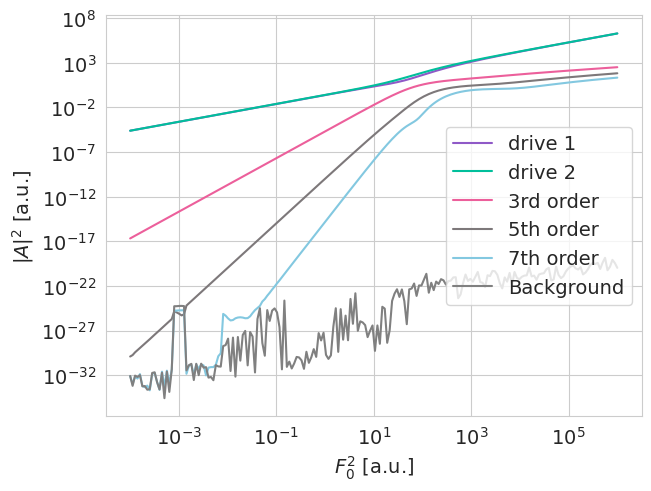

In [42]:
# Plot of IMPs and drive amplitudes
fig, ax = plt.subplots(1)

ax.loglog(F1_arr**2, np.abs(Aout_ii_arr[:, drives_ind[0]])**2, label='drive 1')
ax.loglog(F1_arr**2, np.abs(Aout_ii_arr[:, drives_ind[1]])**2, label='drive 2')
ax.loglog(F1_arr**2, np.abs(Aout_ii_arr[:, drives_ind[1]-nstep])**2, label='3rd order')
ax.loglog(F1_arr**2, np.abs(Aout_ii_arr[:, drives_ind[1]-2*nstep])**2, label='5th order')
ax.loglog(F1_arr**2, np.abs(Aout_ii_arr[:, drives_ind[1]-3*nstep])**2, label='7th order')
ax.loglog(F1_arr**2, np.abs(Aout_ii_arr[:, drives_ind[1]+3])**2, label='Background')

ax.set_ylabel('$|A|^2$ [a.u.]')
ax.set_xlabel('$F_0^2$ [a.u.]')
ax.legend(loc='right')

plt.show()

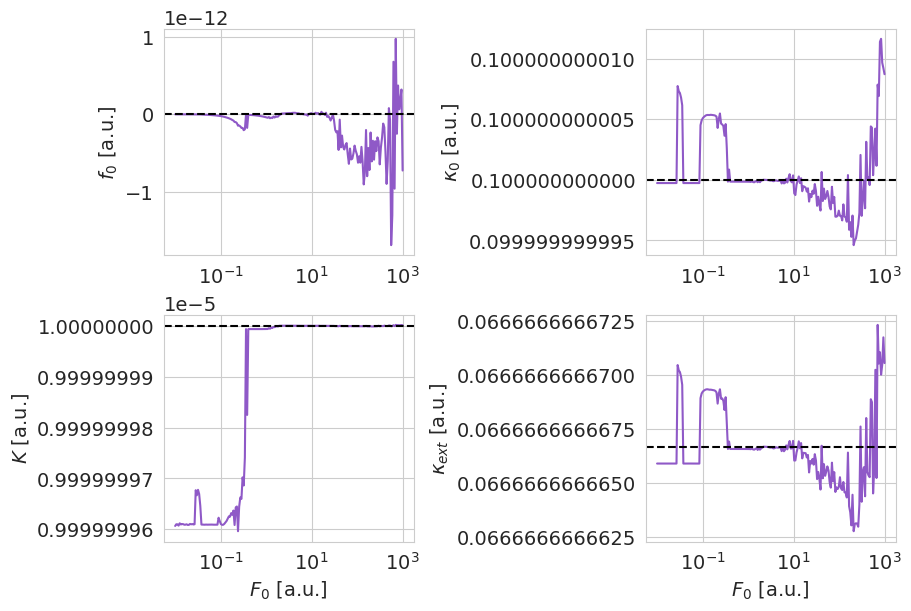

In [43]:
# Plot reconstructed parameters
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

ax[0, 0].semilogx(F1_arr, f0_rec_ii)
ax[0, 0].axhline(f0, ls='--', c='black')
ax[0, 1].semilogx(F1_arr, k0_rec_ii)
ax[0, 1].axhline(k0, ls='--', c='black')
ax[1, 0].semilogx(F1_arr, k_rec_ii)
ax[1, 0].axhline(k, ls='--', c='black')
ax[1, 1].semilogx(F1_arr, kext_rec_ii)
ax[1, 1].axhline(kext, ls='--', c='black')

# labels
ax[1, 0].set_xlabel('$F_0$ [a.u.]')
ax[1, 1].set_xlabel('$F_0$ [a.u.]')
ax[0, 0].set_ylabel('$f_0$ [a.u.]')
ax[1, 0].set_ylabel('$K$ [a.u.]')
ax[0, 1].set_ylabel('$\kappa_0$ [a.u.]')
ax[1, 1].set_ylabel('$\kappa_{ext}$ [a.u.]')

plt.show()